# Twitter Trending Event Detection

## Introduction

In this project, I will work on a real world dataset from Twitter. The ultimate goal of this project is to identify the trending event over time and find out the corresponding tweets.

#### Agenda:
- Data Pre-processing and Exploratory Data Analysis (EDA)
- Anoamly Detection Algorithm Implementation
- Trending Event Detection using Anomaly Detection
- Retrieve tweets related to trending event

#### To be more specific:
- Firstly, for each top keyword or key phrase, I will construct a time-series (daily) based on its number of appearance in the twitter stream.

- Secondly, I will apply the anomaly detection algorithm against the timeseries of each keyword or key phrase, and mark the dates when that keyword or key phrase is identified as *anomaly*.

- Finally, I group the keywords and key phrases together by the dates when they are detected as *anomaly*. 

Therefore, for each date, by combing all the keywords and key phrases that are anomalous in terms of number of appearances, I can have an idea of what topics are trending on that date.

## Dataset

I used datasets from GitHub that collect top 1000 daily terms (from **2020-03-22** to **2020-08-22**) with corresponding frequency.

|Filename|Description|
|---|---|
|DATE_top1000terms.csv | Top 1000 bi-grams ordered by counts from the tweets |

## Environment Setup

In [1]:
%matplotlib inline
from typing import List, Dict, Optional
from datetime import date, timedelta
from collections import Counter, defaultdict

import json
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

## Data Pre-processing

In [2]:
# Get the stopwords list from NLTK
stop_words = set(stopwords.words('english'))

In [3]:
# Optional to add more custom_stopwords
custom_stopwords = ["nan"]
stop_words.update(custom_stopwords)

In [4]:
# Start date and end date of the datasets
start_dt = date(2020,3,22)
end_dt = date(2020,8,22)

In [5]:
# This counter is used to figure out each token's highest count (i.e., all time high count)
terms_counter = Counter()

In [6]:
# Use this dict to remember the count of each token in each daydaily_counts[]
# usage: daily_counts[date_string][token_string], e.g. daily_counts['2020-04-01']['covid19']
daily_counts = defaultdict(dict)

In [7]:
# Use this dict to remember the mininum count among all token in each day
# this dict is used to fill the missing value if one token does not appear in some other date
daily_min_counts = {}

In [8]:
dt = start_dt
while dt <= end_dt:
    # iterating through entire datasets
    with open(f'./dataset/{dt.isoformat()}/{dt.isoformat()}_top1000terms.csv', 'r') as f:
        
        daily_word_count = []
        
        for line in f.readlines():
            token, count = line.strip().split(',')
            count = int(count)
            
            # 1. token should be converted the token to lower case.
            token = token.lower()
            # 2. token should at least have 3 letters.
            token = (token if len(token)>=3 else "N/A")
            # 3. token should consist of alphabet characters or numbers, but not only numbers
            token = (token if token.isalnum() and not token.isdigit() else "N/A")
            # 4. token should not be stopwords
            token = (token if token not in stop_words else "N/A")
            
            # Fill the terms_counter, daily_counts and daily_min_couts
            dt_str = dt.isoformat() 
            
            if token != "N/A":
                daily_counts[dt_str][token] = count
                
                if terms_counter[token] < count:
                    terms_counter[token] = count
                
                daily_word_count.append(count)
            
        daily_min_counts[dt_str] = min(daily_word_count)
       
    dt += timedelta(days=1)

## EDA

In [9]:
print(f'Number of eligible tokens: {len(terms_counter)}')
print(f'Top 5 tokens with counts:\n{terms_counter.most_common(5)}')

Number of eligible tokens: 4114
Top 5 tokens with counts:
[('coronavirus', 365236), ('covid', 255660), ('covid19', 248841), ('trump', 75936), ('cases', 60019)]


In [10]:
# See the mininum count on 2022-03-22
daily_min_counts['2020-03-22']

872

In [11]:
# Use Counter.most_common(N) function to select topN eligible tokens
topN = 1000
selected_tokens = [x for x, _ in terms_counter.most_common(topN)]

In [12]:
selected_tokens[:5]

['coronavirus', 'covid', 'covid19', 'trump', 'cases']

In [13]:
# This timeseries variable stores all the tokens and their timeseries in key, value format
timeseries = defaultdict(list)

# Since all the timeseries should have same timetamps range, put them into this `ts_idx` list
ts_idx = []

In [14]:
dt = start_dt
while dt <= end_dt:
    dt_str = dt.isoformat()
    ts_idx.append(dt_str)
    for token in selected_tokens:
        # construct the timeseries using `daily_counts`
        # if a token does not have count for that date,
        # use that day's minimum count minus 1 to fill it
        try:
            timeseries[token].append(daily_counts[dt_str][token])
        except:
            timeseries[token].append(daily_min_counts[dt_str]-1)
        
    dt += timedelta(days=1)

In [15]:
# Have a look at ts_idx to make sure you know its format
print(ts_idx[:10])
print(len(ts_idx))

['2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31']
154


In [16]:
# Have a look of raw time-series for token `covid`
print(timeseries['covid'])

[67037, 84031, 91123, 90652, 128786, 134682, 116419, 116988, 139430, 146153, 145358, 146368, 148479, 146388, 147042, 164911, 168594, 176088, 186855, 172071, 153534, 167386, 202958, 200246, 194092, 212290, 188075, 174264, 186944, 202177, 224951, 255660, 212241, 193133, 186974, 202960, 219733, 225712, 237720, 232681, 169041, 193697, 203800, 227738, 226726, 238683, 243692, 252701, 236785, 189520, 226871, 243658, 226747, 251465, 251029, 216289, 194643, 206824, 201255, 199509, 246092, 241074, 194693, 188803, 216674, 246165, 253685, 226260, 225451, 185472, 175614, 201258, 219113, 224508, 218070, 209458, 171276, 162570, 213864, 216173, 212951, 230501, 208480, 160232, 150398, 210797, 224025, 224189, 215140, 213987, 178016, 152390, 209028, 221034, 204587, 221829, 211967, 183500, 166035, 215507, 203613, 218067, 212170, 206981, 164436, 181446, 214526, 238524, 220280, 223908, 219880, 155299, 178734, 218255, 227139, 211307, 227539, 217091, 163477, 165303, 219258, 220434, 225435, 219940, 204673, 153

In [17]:
def plot_ts(ts: List[float], labels: List[str] = None) -> None:
    if not labels:
        labels = list(range(len(ts)))
    plt.plot(labels, ts)
    plt.grid()
    plt.xlabel('date')
    plt.ylabel('# of appearance')
    plt.show()

def token_trend(token: str):
    plot_ts(timeseries[token])

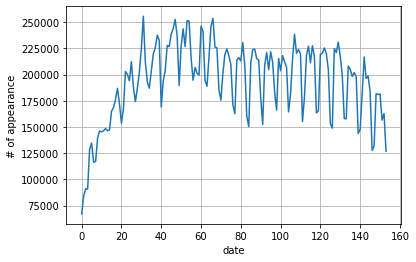

In [18]:
token_trend('covid')

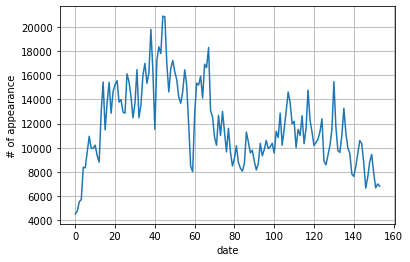

In [19]:
token_trend('death')

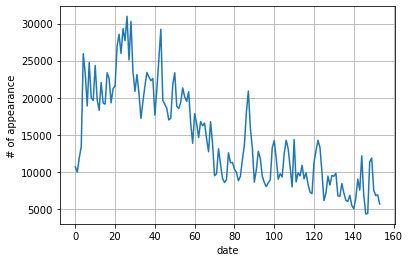

In [20]:
token_trend('china')

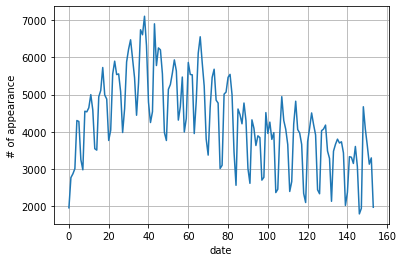

In [21]:
token_trend('online')

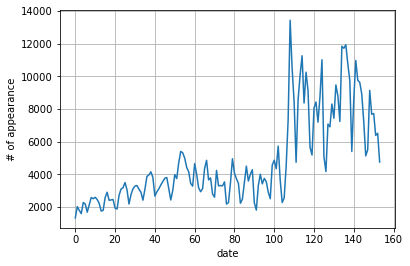

In [22]:
# TODO (optional): Feel free to pick any other token that you many want to check its trend as well
token_trend('school')

## Anomaly Detection Algorithm Implementation

In [23]:
import numpy as np
import statsmodels.api as sm
from statsmodels.robust.scale import mad
from scipy.stats import t as student_t

In [24]:
def stl(series: np.ndarray, period: int):
    """
    Seasonal-Trend decomposition
    series : numpy.array
        Time-series in ndarry
    periood : int
        Period of the seasonal component.
        For example, if the  time series is monthly with a yearly cycle, then
        freq=12.
    """
    decomp = sm.tsa.seasonal_decompose(series, period=period)
    return decomp.seasonal, decomp.trend, decomp.resid

In [25]:
seasonal, trend, resid = stl(np.array(timeseries['covid']), period=7)

Original Timeseries


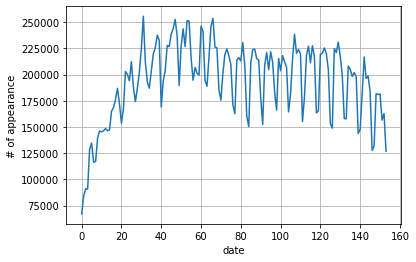

Seasonal Component


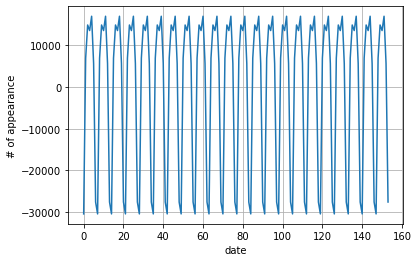

Trend Component


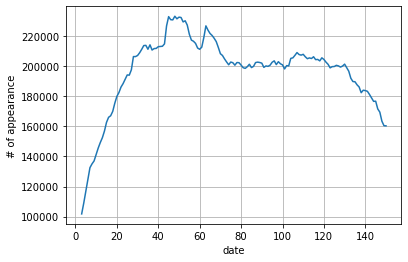

Residual Component


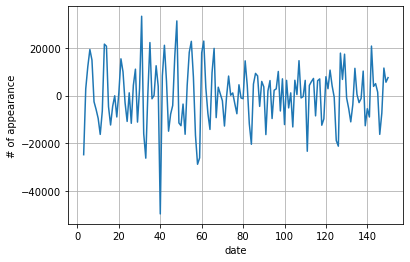

In [26]:
print('Original Timeseries')
plot_ts(timeseries['covid'])
print('Seasonal Component')
plot_ts(seasonal)
print('Trend Component')
plot_ts(trend)
print('Residual Component')
plot_ts(resid)

In [27]:
from statsmodels.robust.scale import mad
from scipy.stats import t as student_t
import math

In [28]:
def robust_seasonal_esd_test(ts, max_anom=5, seasonal=False, period=None, alpha=0.05, threshold=1.0):
    """Robust Seasonal Extreme Studentized Deviate Test"""
  
    series = np.copy(ts)
    if len(ts) != len(ts_idx):
        print(f"Bad timeseries, length={len(ts)}")
        return []
    
    # Implement the seasonal decomposition as an option
    if seasonal:
        if not period:
            raise RuntimeError("Period must be set if the time series is seasonal")
        # Remove the seasonal signal and median (based on the paper)
        series = series - stl(ts, period=7)[0] - np.median(series)
    
    N = len(series)
    ts_index = np.array(range(N))
    
    anom_list = []
    n_anom = 0
    for k in range(1, max_anom+1):
        
        # Compute the test statistic C_k
        C_k = max(abs(series-np.median(series)))/mad(series)
        
        # Determine the direction or anomaly
        direction = ("positive" if max(abs(series-np.median(series))) in series-np.median(series) else "negative")
        
        # Compute the critical value
        p = 1 - alpha / (2 * (N - k + 1))
        t = student_t.ppf(p, N - k - 1)
        lambda_k = (N - k) * t / ((N - k - 1+ t**2)*(N - k +1))**0.5


        # The score is defined as C_k / lambda_k
        # If the score > threshold, then take this data point as an anomaly
        score = C_k / lambda_k
        if score > threshold:
            n_anom = k
        else:
            break
        
        max_idx = np.argmax(abs(series-np.median(series)))
        
        anom_list.append({
            "rank": k,
            "index": int(ts_index[max_idx]),
            "value": float(ts[ts_index[max_idx]]),
            "direction": direction,
            "score": round(score, 2)
        })
            
        # Remove the identified value from both time-series and index
        series = np.delete(series, max_idx)
        ts_index = np.delete(ts_index, max_idx)
    return anom_list

In [29]:
def plot_anomaly_on_ts(ts: List[float], anom_index_list: List[int], anom_value_list: List[int]) -> None:
    """
    Plot timeseries chart together with detected anomalies as scatter points
    ts:
        The values of timeseries
    
    anom_index_list:
        The list of timeseries index for the detected anomalies, for instance, if the 2nd data point
        is identified as anomaly, the index will be 1 (since it starts from 0)
    
    anom_value_list:
        The list of values for the detected anomalies
    """
    labels = list(range(len(ts)))
    plt.plot(labels, ts)
    plt.scatter(anom_index_list, anom_value_list, s=50.0, c='red')
    plt.grid()
    plt.xlabel('date')
    plt.ylabel('# of appearance')
    plt.show()

def pretty_print(struct):
    """
    struct:
        The struct can be anything that is JSON serializable, like dictionary, or list.
    """
    print(json.dumps(struct, indent=2))

In [30]:
def plot_anomalies(term):
    
    ts = np.array(timeseries[term])
    anom_list = robust_seasonal_esd_test(ts, threshold=1.1)

    # Only keep anomalies going up
    anom_index = []
    anom_value = []

    for i in anom_list:
        if i['direction'] == 'positive':
            anom_index.append(i['index'])
            anom_value.append(i['value'])

    plot_anomaly_on_ts(ts, anom_index, anom_value)

## Anomaly and Trending Event Detection 

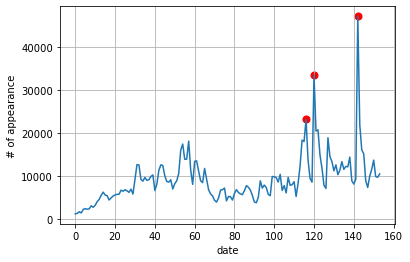

In [31]:
plot_anomalies("vaccine")

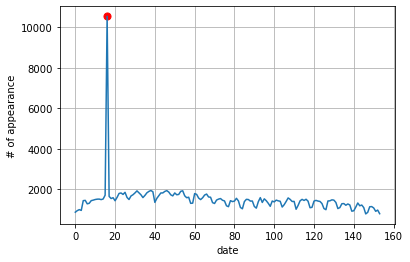

In [32]:
plot_anomalies("worldhealthday")

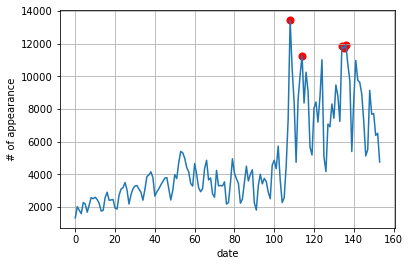

In [33]:
plot_anomalies("school")

In [34]:
# I have already had the timeseries index: ts_idx
print(f'length={len(ts_idx)}')
print(ts_idx[:3])

length=154
['2020-03-22', '2020-03-23', '2020-03-24']


In [35]:
# I will use this dict to remember the anomalous token for each date
# format: daily_anom_tokens[date_string][anomalous_token] = anom_dict_from_the_algorithm
daily_anom_tokens = defaultdict(dict)

In [36]:
all_tokens = timeseries.keys()

In [37]:
for token in all_tokens:
    ts = np.array(timeseries[token])
    anom_list = robust_seasonal_esd_test(ts, threshold=1.1)

In [38]:
daily_anom_tokens = defaultdict(dict)

all_tokens = timeseries.keys()

for token in all_tokens:
    
    # Apply positive anomaly detection for the timeseries of all tokens.
    ts = np.array(timeseries[token])
    anom_list = robust_seasonal_esd_test(ts, threshold=1.1)
    
    anom_index = []
    anom_value = []
    
    for i in anom_list:
        if i['direction'] == 'positive':
            
            anom_index.append(i['index'])
            anom_value.append(i['value'])
    
    for idx, value in zip(anom_index, anom_value):
        daily_anom_tokens[ts_idx[idx]][token] = value

In [39]:
# Show top tearms by date
for date in sorted(daily_anom_tokens.keys()):
    
    ordered_tokens = sorted(daily_anom_tokens[date].items(), 
                                           key=lambda item:item[1], 
                                           reverse=True)
    print(date)
    for token, score in ordered_tokens:
        space = ' '*(27-len(token))
        print(f'{token}{space}{score}')
    print()

2020-03-22
coronaviruspandemic        12216.0
italy                      10741.0
friends                    5907.0
italian                    5380.0
stand                      5153.0
stayathome                 4652.0
colleagues                 4548.0

2020-03-23
italy                      6816.0
democrats                  5356.0
senate                     3489.0
italian                    2844.0
stand                      2700.0
colleagues                 2359.0

2020-03-24
self                       5703.0
hantavirus                 4797.0

2020-03-25
charles                    7354.0
prince                     7256.0
stimulus                   5630.0
senate                     5347.0
deal                       4737.0
trillion                   4584.0
package                    4302.0

2020-03-26
covid2019                  18005.0
coronaviruspandemic        8983.0
italy                      7074.0
self                       6377.0
march                      5995.0
stimulus            

## Real Event Validation


- Mar 24, 2020 [People are worrying about the hantavirus](https://www.deseret.com/u-s-world/2020/3/24/21192254/coronavirus-covid-19-hantavirus-china-india-nyc-global-times-prevention-symptoms)
- Mar 27, 2020 [Coronavirus strikes UK Prime Minister Boris Johnson](https://www.cnn.com/2020/03/27/uk/uk-boris-johnson-coronavirus-gbr-intl/index.html)
- April 7, 2020 [World Health Day](https://www.who.int/campaigns/world-health-day/world-health-day-2020)
- April 29, 2020 [NIH clinical trial shows Remdesivir accelerates recovery from advanced COVID-19](https://www.nih.gov/news-events/news-releases/nih-clinical-trial-shows-remdesivir-accelerates-recovery-advanced-covid-19)
- May 11, 2020 [What is 'Obamagate' and why is Trump so worked up about it?](https://www.theguardian.com/us-news/2020/may/12/what-is-obamagate-and-why-is-trump-so-worked-up-about-it)
- May 29, 2020 [Monkey steals COVID-19 blood samples from a lab technician in India](https://www.livescience.com/monkey-steals-covid-19-blood-samples.html)
- June 4, 2020 [5 things to know for June 4: George Floyd, protests, coronavirus, stimulus, oil spill](https://www.cnn.com/2020/06/04/us/five-things-june-4-trnd/index.html)
- June 13, 2020 [Beijing closes market, locks down area in new virus outbreak](https://medicalxpress.com/news/2020-06-beijing-area-virus-outbreak.html)
- ...
- July 20, 2020 [Coronavirus vaccine from Oxford and AstraZeneca shows positive response in early trial](https://www.cnbc.com/2020/07/20/oxford-universitys-coronavirus-vaccine-shows-positive-immune-response-in-an-early-trial.html)
- July 30, 2020 [Herman Cain, Former C.E.O. and Presidential Candidate, Dies at 74](https://www.nytimes.com/2020/07/30/us/politics/herman-cain-dead.html)
- August 11, 2020 [Putin claims Russia has registered the world’s first coronavirus vaccine, says his daughter has taken it](https://www.cnbc.com/2020/08/11/russia-claims-to-have-registered-first-coronavirus-vaccine.html)